In [6]:
# NBVAL_IGNORE_OUTPUT
from secml.data.loader import CDataLoaderMNIST

import numpy as np
from secml.array import CArray

from secml.ml.classifiers import CClassifierLogistic
from secml.ml.peval.metrics import CMetricAccuracy
from secml.adv.attacks import CAttackPoisoningLogisticRegression

import matplotlib.pyplot as plt

In [2]:
# MNIST dataset will be downloaded and cached if needed
loader = CDataLoaderMNIST()

In [13]:
random_state = 999

n_tr = 100  # Number of training set samples
n_val = 500  # Number of validation set samples
n_ts = 500  # Number of test set samples

# digits = (5, 9)
# digits = (2, 7)
digits = (3, 8)

tr_val = loader.load('training', digits=digits, num_samples=n_tr + n_val)
ts = loader.load('testing', digits=digits, num_samples=n_ts)

# Split in training and validation set
tr = tr_val[:n_tr, :]
val = tr_val[n_tr:, :]

# Normalize the features in `[0, 1]`
tr.X /= 255
val.X /= 255
ts.X /= 255

In [14]:
def multidimensional_descent(tr_data, k, num_itr):

    metric = CMetricAccuracy()

    clf, Y_prev = None, None
    clf = CClassifierLogistic()
    n, d = tr_data.X.shape
    Y = np.linalg.svd(np.random.randn(d, k))[0][:, :k]
    for i in range(num_itr):
        XY = CArray(tr_data.X.tondarray()@Y)
        clf.fit(XY, tr_data.Y)
        # Compute x
        x = Y@clf.w.tondarray().reshape(-1, 1)
        if i%10 == 0:
            XtY = CArray(ts.X.tondarray()@Y)
            y_pred = clf.predict(XtY)
            acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)
            print(acc)
        x_unit = x/np.linalg.norm(x)
        U = np.linalg.svd(np.eye(d)-x_unit@x_unit.T)[0][:, :d-1]
        V = np.linalg.svd(np.random.randn(d-1, d-1))[0][:, :k-1]
        Y_prev = np.copy(Y)
        Y[:, :1], Y[:, 1:] = x_unit, U@V

    return x, clf, Y_prev

In [6]:
# train SVM in the dual space, on a linear kernel, as needed for poisoning
clf = CClassifierLogistic()

print("Training of classifier...")
clf.fit(tr.X, tr.Y)

# Compute predictions on a test set
y_pred = clf.predict(ts.X)

# Metric to use for performance evaluation
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()

# Evaluate the accuracy of the classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)

print("Accuracy on test set: {:.2%}".format(acc))

Training of classifier...
Accuracy on test set: 94.60%


## Generating Attacks

In [27]:
lb, ub = 0., 1.  # Bounds of the attack space. Can be set to `None` for unbounded
n_poisoning_points = 25  # Number of poisoning points to generate

# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.25,
    'eta_min': 2.0,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}

from secml.adv.attacks import CAttackPoisoningLogisticRegression
pois_attack = CAttackPoisoningLogisticRegression(classifier=clf,
                                  training_data=tr,
                                  val=val,
                                  lb=lb, ub=ub,
                                  solver_params=solver_params,
                                  random_seed=random_state)

pois_attack.n_points = n_poisoning_points

# Run the poisoning attack
print("Attack started...")
pois_y_pred, _, pois_points_ds, _ = pois_attack.run(ts.X, ts.Y)
print("Attack complete!")

# Evaluate the accuracy of the original classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=clf.predict(ts.X))
# Evaluate the accuracy after the poisoning attack
pois_acc = metric.performance_score(y_true=ts.Y, y_pred=pois_y_pred)

print("Original accuracy on test set: {:.2%}".format(acc))
print("Accuracy after attack on test set: {:.2%}".format(pois_acc))

# Training of the poisoned classifier for visualization purposes
# pois_clf = clf.deepcopy()
# pois_tr = tr.append(pois_points_ds)  # Join the training set with the poisoning points
# pois_clf = pois_clf.fit(pois_tr.X, pois_tr.Y)

Attack started...
2024-05-19 10:51:22,936 - COptimizerPGDLS.0x7f829d032c70 - WARNING - Maximum iterations reached. Exiting.
2024-05-19 10:51:58,797 - COptimizerPGDLS.0x7f829d02b400 - WARNING - Maximum iterations reached. Exiting.
2024-05-19 10:52:18,309 - COptimizerPGDLS.0x7f829d02ad30 - WARNING - Maximum iterations reached. Exiting.
2024-05-19 10:52:50,929 - COptimizerPGDLS.0x7f829e0ba730 - WARNING - Maximum iterations reached. Exiting.
2024-05-19 10:53:09,769 - COptimizerPGDLS.0x7f829e0ba730 - WARNING - Maximum iterations reached. Exiting.
Attack complete!
Original accuracy on test set: 94.60%
Accuracy after attack on test set: 61.80%


In [15]:
# Bounds of the attack space. Can be set to `None` for unbounded
lb, ub = 0., 1.

# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.25,
    'eta_min': 2.0,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}

n_pois_points_arr = [10, 15, 20, 25, 30]
k_arr = [3, 5, 8]
num_itr = 20
num_trials = 10

pois_acc_full = np.zeros(len(n_pois_points_arr))
pois_acc_k = np.zeros((len(n_pois_points_arr), len(k_arr), num_trials))

metric = CMetricAccuracy()

# train SVM in the dual space, on a linear kernel, as needed for poisoning
clf = CClassifierLogistic()
clf.fit(tr.X, tr.Y)
acc_full = metric.performance_score(y_true=ts.Y, y_pred=clf.predict(ts.X))
pois_attack = CAttackPoisoningLogisticRegression(classifier=clf,
                                  training_data=tr,
                                  val=val,
                                  lb=lb, ub=ub,
                                  solver_params=solver_params,
                                  random_seed=random_state)

for inp, n_pois_points in enumerate(n_pois_points_arr):

    pois_attack.n_points = n_pois_points
    pois_y_pred, _, pois_points_ds, _ = pois_attack.run(ts.X, ts.Y)
    pois_acc_full[inp] = metric.performance_score(y_true=ts.Y, y_pred=pois_y_pred) 
    pois_tr = tr.append(pois_points_ds)

    for ik, k in enumerate(k_arr):
        for i in range(num_trials):
            x_m, clf_m, Y = multidimensional_descent(pois_tr, k, num_itr)    
            XtY = CArray(ts.X.tondarray()@Y)
            y_pred = clf_m.predict(XtY)
            acc_ = metric.performance_score(y_true=ts.Y, y_pred=y_pred)
            pois_acc_k[inp, ik, i] = acc_

2024-05-19 12:36:01,309 - COptimizerPGDLS.0x7fd2af085d90 - WARNING - Maximum iterations reached. Exiting.
2024-05-19 12:36:16,509 - COptimizerPGDLS.0x7fd2af085b20 - WARNING - Maximum iterations reached. Exiting.
2024-05-19 12:36:34,544 - COptimizerPGDLS.0x7fd2af085d30 - WARNING - Maximum iterations reached. Exiting.
0.644
0.778
0.54
0.78
0.616
0.754
0.584
0.808
0.542
0.762
0.656
0.76
0.63
0.81
0.518
0.672
0.496
0.766
0.576
0.66
0.508
0.728
0.686
0.826
0.662
0.79
0.62
0.788
0.668
0.79
0.722
0.78
0.76
0.762
0.564
0.802
0.586
0.792
0.692
0.824
0.678
0.82
0.73
0.834
0.756
0.778
0.47
0.816
0.692
0.838
0.752
0.822
0.722
0.792
0.744
0.806
0.736
0.81
0.644
0.78
2024-05-19 12:42:24,280 - COptimizerPGDLS.0x7fd296e821c0 - WARNING - Maximum iterations reached. Exiting.
2024-05-19 12:42:49,098 - COptimizerPGDLS.0x7fd296e96820 - WARNING - Maximum iterations reached. Exiting.
2024-05-19 12:43:06,741 - COptimizerPGDLS.0x7fd296e96280 - WARNING - Maximum iterations reached. Exiting.
0.688
0.772
0.564
0.

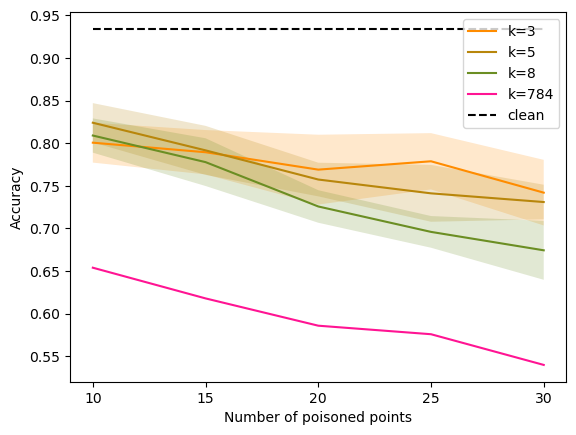

In [16]:
# Plotting code
colors = ['darkorange', 'darkgoldenrod', 'olivedrab', 'dodgerblue', 'deeppink', 'crimson']

t = np.arange(len(n_pois_points_arr))
fig, ax = plt.subplots(1)
for ik, k in enumerate(k_arr):
    mu = np.mean(pois_acc_k[:, ik, :], axis=-1)
    sigma = np.std(pois_acc_k[:, ik, :], axis=-1)
    ax.plot(t, mu, label=f"k={k}", color=colors[ik])
    ax.fill_between(t, mu+sigma, mu-sigma, facecolor=colors[ik], alpha=0.2)
ax.plot(t, pois_acc_full, label=f'k={tr.X.shape[1]}', color=colors[-2])
ax.plot(t, acc_full*np.ones(len(t)), '--', label='clean', color='black')
ax.set_xticks(ticks=t, labels=n_pois_points_arr)
ax.set_xlabel("Number of poisoned points")
ax.set_ylabel("Accuracy")
ax.legend()
plt.savefig(f'log_reg_{digits[0]}_{digits[1]}.png', bbox_inches='tight')
plt.show()